In [1]:
import pandas as pd 
import math, random
all_data  = pd.read_csv("sensor_data_200.txt", delimiter=" ", header=None, names = ("date","time","ir","z"))#lidarのセンサ値は「z」に
data = all_data.sample(3000).sort_values(by="z").reset_index()  #1000個だけサンプリングしてインデックスを振り直す
data = pd.DataFrame(data["z"])

In [2]:
##負担率の初期化## 

K = 3 #クラスタ数
n = int(math.ceil(len(data)/K)) #クラスタあたりのセンサ値の数
for k in range(K):
    data[k] = [1.0 if k == int(i/n) else 0.0 for i,d in data.iterrows()] #データをK個に分けて、一つのr_{i,k}を1に。他を0に。

In [3]:
def update_parameters(ds, k, mu_avg=200, zeta=1, alpha=1, beta=1, tau=1): 
    R = sum([d[k] for _, d in ds.iterrows()])
    S = sum([d[k]*d["z"] for _, d in ds.iterrows()])
    T = sum([d[k]*(d["z"]**2) for _, d in ds.iterrows()])
    
    hat = {}

    hat["tau"] = R + tau
    hat["zeta"] = R + zeta
    hat["mu_avg"] = (S + zeta*mu_avg)/hat["zeta"]
    hat["alpha"] = R/2 + alpha
    hat["beta"] = (T + zeta*(mu_avg**2) - hat["zeta"]*(hat["mu_avg"]**2))/2 + beta
    
    hat["z_std"] = math.sqrt(hat["beta"]/hat["alpha"])
    
    return pd.DataFrame(hat, index=[k])

In [4]:
from scipy.stats import norm, dirichlet
import matplotlib.pyplot as plt
import numpy as np

def draw(ps):
    pi = dirichlet([ps["tau"][k] for k in range(K)]).rvs()[0]
    pdfs = [ norm(loc=ps["mu_avg"][k], scale=ps["z_std"][k]) for k in range(K) ]

    xs = np.arange(190,230,0.5)

    ##p(z)の描画##
    ys = [ sum([pdfs[k].pdf(x)*pi[k] for k in range(K)])*len(data) for x in xs] #pdfを足してデータ数をかける
    plt.plot(xs, ys, color="red")

    ##各ガウス分布の描画##
    for k in range(K):
        ys = [pdfs[k].pdf(x)*pi[k]*len(data) for x in xs]
        plt.plot(xs, ys, color="blue")

    ##元のデータのヒストグラムの描画##
    data["z"].hist(bins = max(data["z"]) - min(data["z"]), align='left', alpha=0.4, color="gray")
    plt.show()

In [5]:
from scipy.special import digamma 

def responsibility(z, K, ps):
    tau_sum = sum([ps["tau"][k] for k in range(K)])
    r = {}
    for k in range(K):
        log_rho = (digamma(ps["alpha"][k]) - math.log(ps["beta"][k]))/2 \
                            - (1/ps["zeta"][k] + ((ps["mu_avg"][k] - z)**2)*ps["alpha"][k]/ps["beta"][k])/2 \
                            + digamma(ps["tau"][k]) - digamma(tau_sum)
                
        r[k] = math.exp(log_rho)
       
    w = sum([ r[k] for k in range(K) ]) #正規化
    for k in range(K): r[k] /= w
    
    return r

In [6]:
def one_step(ds): ###variationalinference2onestep
    ##パラメータの更新##
    params = pd.concat([update_parameters(ds, k) for k in range(K)]) 

    ##負担率の更新##
    rs = [responsibility(d["z"], K, params) for _, d in ds.iterrows() ]
    for k in range(K):
        ds[k] = [rs[i][k] for i,_ in data.iterrows()]
        
    return ds, params

In [7]:
params_history = {} ###variationalinference2iter
for t in range(1, 10000):
    data, params = one_step(data)
    if t%10 ==0:              #10回ごとにパラメータを記録
        params_history[t] = params
        display(params)
        
        if len(params_history) < 2:
            continue
           
        if all([ abs(params_history[t-10]["tau"][k] - params_history[t]["tau"][k]) < 10e-5 for k in range(K)]):
            break

,tau,zeta,mu_avg,alpha,beta,z_std
0,1017.351576,1017.351576,204.863798,509.175788,4167.085746,2.860766
1,891.652255,891.652255,209.474450,446.326127,2182.511912,2.211323
2,1093.996170,1093.996170,214.555711,547.498085,4695.431563,2.928508


,tau,zeta,mu_avg,alpha,beta,z_std
0,992.149113,992.149113,204.956920,496.574556,4421.021450,2.983796
1,878.326094,878.326094,209.305862,439.663047,2717.587509,2.486176
2,1132.524793,1132.524793,214.329412,566.762396,5359.382106,3.075083


,tau,zeta,mu_avg,alpha,beta,z_std
0,967.792943,967.792943,204.991492,484.396472,4482.183072,3.041896
1,872.143327,872.143327,209.164867,436.571663,3043.002179,2.640118
2,1163.063730,1163.063730,214.183395,582.031865,5794.791932,3.155335


,tau,zeta,mu_avg,alpha,beta,z_std
0,945.046379,945.046379,205.006142,473.023189,4480.506751,3.077672
1,868.125296,868.125296,209.038164,434.562648,3273.414067,2.744570
2,1189.828326,1189.828326,214.071529,595.414163,6138.340859,3.210820


,tau,zeta,mu_avg,alpha,beta,z_std
0,923.731388,923.731388,205.011604,462.365694,4450.973225,3.102664
1,865.085656,865.085656,208.920799,433.042828,3448.253619,2.821852
2,1214.182956,1214.182956,213.979252,607.591478,6430.934214,3.253353


,tau,zeta,mu_avg,alpha,beta,z_std
0,903.635712,903.635712,205.012103,452.317856,4407.126320,3.121446
1,862.587345,862.587345,208.810403,431.793672,3585.839043,2.881756
2,1236.776944,1236.776944,213.899954,618.888472,6690.394899,3.287908


,tau,zeta,mu_avg,alpha,beta,z_std
0,884.585216,884.585216,205.009612,442.792608,4355.291629,3.136234
1,860.431739,860.431739,208.705675,430.715869,3696.256112,2.929447
2,1257.983045,1257.983045,213.830021,629.491522,6926.163195,3.317045


,tau,zeta,mu_avg,alpha,beta,z_std
0,866.442112,866.442112,205.005144,433.721056,4298.787739,3.148239
1,858.517258,858.517258,208.605835,429.758629,3785.738635,2.967994
2,1278.040630,1278.040630,213.767227,639.520315,7143.895630,3.342261


,tau,zeta,mu_avg,alpha,beta,z_std
0,849.096437,849.096437,204.999245,425.048219,4239.499863,3.158190
1,856.788384,856.788384,208.510385,428.894192,3858.490663,2.999395
2,1297.115178,1297.115178,213.710086,649.057589,7347.284892,3.364510


,tau,zeta,mu_avg,alpha,beta,z_std
0,832.459009,832.459009,204.992220,416.729505,4178.563187,3.166550
1,855.213892,855.213892,208.418991,428.106946,3917.550470,3.025040
2,1315.327099,1315.327099,213.657549,658.163549,7538.897388,3.384441


,tau,zeta,mu_avg,alpha,beta,z_std
0,816.456357,816.456357,204.984240,408.728179,4116.692648,3.173635
1,853.776360,853.776360,208.331419,427.388180,3965.238945,3.045955
2,1332.767282,1332.767282,213.608840,666.883641,7720.601820,3.402519


,tau,zeta,mu_avg,alpha,beta,z_std
0,801.027129,801.027129,204.975402,401.013564,4054.354910,3.179665
1,852.466650,852.466650,208.247495,426.733325,4003.407660,3.062927
2,1349.506221,1349.506221,213.563371,675.253110,7893.806698,3.419085


,tau,zeta,mu_avg,alpha,beta,z_std
0,786.119502,786.119502,204.965760,393.559751,3991.863553,3.184802
1,851.280779,851.280779,208.167082,426.140389,4033.582657,3.076587
2,1365.599719,1365.599719,213.520682,683.299860,8059.600525,3.434402


,tau,zeta,mu_avg,alpha,beta,z_std
0,771.689274,771.689274,204.955345,386.344637,3929.434203,3.189169
1,850.218040,850.218040,208.090065,425.609020,4057.050749,3.087449
2,1381.092686,1381.092686,213.480409,691.046343,8218.839131,3.448670


,tau,zeta,mu_avg,alpha,beta,z_std
0,757.698407,757.698407,204.944175,379.349204,3867.217702,3.192859
1,849.279824,849.279824,208.016341,425.139912,4074.913107,3.095945
2,1396.021768,1396.021768,213.442262,698.510884,8372.202852,3.462050


,tau,zeta,mu_avg,alpha,beta,z_std
0,744.113891,744.113891,204.932262,372.556946,3805.320701,3.195945
1,848.468843,848.468843,207.945812,424.734422,4088.119753,3.102438
2,1410.417266,1410.417266,213.406005,705.708633,8520.235801,3.474666


,tau,zeta,mu_avg,alpha,beta,z_std
0,730.906838,730.906838,204.919615,365.953419,3743.818718,3.198486
1,847.788603,847.788603,207.878385,424.394301,4097.492915,3.107237
2,1424.304559,1424.304559,213.371448,712.652280,8663.374166,3.486621


,tau,zeta,mu_avg,alpha,beta,z_std
0,718.051745,718.051745,204.906241,359.525872,3682.764663,3.200530
1,847.243041,847.243041,207.813965,424.121521,4103.743914,3.110606
2,1437.705214,1437.705214,213.338435,719.352607,8801.967492,3.497993


,tau,zeta,mu_avg,alpha,beta,z_std
0,705.525892,705.525892,204.892145,353.262946,3622.194498,3.202114
1,846.836271,846.836271,207.752456,423.918136,4107.486340,3.112770
2,1450.637836,1450.637836,213.306839,725.818918,8936.295404,3.508848


,tau,zeta,mu_avg,alpha,beta,z_std
0,693.308850,693.308850,204.877331,347.154425,3562.131030,3.203270
1,846.572403,846.572403,207.693763,423.786202,4109.247094,3.113922
2,1463.118747,1463.118747,213.276554,732.059373,9066.581078,3.519238


,tau,zeta,mu_avg,alpha,beta,z_std
0,681.382066,681.382066,204.861801,341.191033,3502.586568,3.204023
1,846.455418,846.455418,207.637790,423.727709,4109.476163,3.114224
2,1475.162516,1475.162516,213.247494,738.081258,9193.002378,3.529203


,tau,zeta,mu_avg,alpha,beta,z_std
0,669.728537,669.728537,204.845554,335.364269,3443.564780,3.204393
1,846.489085,846.489085,207.584441,423.744543,4108.555559,3.113813
2,1486.782378,1486.782378,213.219586,743.891189,9315.701133,3.538776


,tau,zeta,mu_avg,alpha,beta,z_std
0,658.332533,658.332533,204.828586,329.666266,3385.062070,3.204395
1,846.676914,846.676914,207.533618,423.838457,4106.807539,3.112806
2,1497.990553,1497.990553,213.192769,749.495277,9434.790872,3.547984


,tau,zeta,mu_avg,alpha,beta,z_std
0,647.179378,647.179378,204.810891,324.089689,3327.068599,3.204043
1,847.022124,847.022124,207.485228,424.011062,4104.502259,3.111298
2,1508.798498,1508.798498,213.166991,754.899249,9550.363258,3.556849


,tau,zeta,mu_avg,alpha,beta,z_std
0,636.255278,636.255278,204.792457,318.627639,3269.569117,3.203344
1,847.527637,847.527637,207.439178,424.263819,4101.864708,3.109372
2,1519.217084,1519.217084,213.142207,760.108542,9662.493383,3.565388


,tau,zeta,mu_avg,alpha,beta,z_std
0,625.547177,625.547177,204.773270,313.273589,3212.543642,3.202305
1,848.196084,848.196084,207.395376,424.598042,4099.081054,3.107093
2,1529.256738,1529.256738,213.118376,765.128369,9771.244037,3.573615


,tau,zeta,mu_avg,alpha,beta,z_std
0,615.042649,615.042649,204.753310,308.021324,3155.968053,3.200928
1,849.029822,849.029822,207.353735,425.014911,4096.304254,3.104517
2,1538.927530,1538.927530,213.095465,769.963765,9876.669120,3.581542


,tau,zeta,mu_avg,alpha,beta,z_std
0,604.729807,604.729807,204.732555,302.864903,3099.814639,3.199215
1,850.030957,850.030957,207.314167,425.515478,4093.659016,3.101688
2,1548.239236,1548.239236,213.073441,774.619618,9978.816291,3.589180


,tau,zeta,mu_avg,alpha,beta,z_std
0,594.597243,594.597243,204.710977,297.798622,3044.052554,3.197163
1,851.201376,851.201376,207.276591,426.100688,4091.246125,3.098644
2,1557.201381,1557.201381,213.052276,779.100690,10077.728974,3.596537


,tau,zeta,mu_avg,alpha,beta,z_std
0,584.633970,584.633970,204.688545,292.816985,2988.648281,3.194768
1,852.542779,852.542779,207.240925,426.771390,4089.146176,3.095413
2,1565.823251,1565.823251,213.031943,783.411625,10173.447838,3.603621


,tau,zeta,mu_avg,alpha,beta,z_std
0,574.829384,574.829384,204.665226,287.914692,2933.566064,3.192023
1,854.056714,854.056714,207.207093,427.528357,4087.422748,3.092020
2,1574.113901,1574.113901,213.012416,787.556951,10266.011823,3.610438


,tau,zeta,mu_avg,alpha,beta,z_std
0,565.173234,565.173234,204.640980,283.086617,2878.768282,3.188920
1,855.744614,855.744614,207.175019,428.372307,4086.125090,3.088482
2,1582.082153,1582.082153,212.993673,791.541076,10355.458794,3.616995


,tau,zeta,mu_avg,alpha,beta,z_std
0,555.655595,555.655595,204.615765,278.327798,2824.215839,3.185449
1,857.607827,857.607827,207.144632,429.303914,4085.290387,3.084814
2,1589.736578,1589.736578,212.975692,795.368289,10441.825937,3.623298


,tau,zeta,mu_avg,alpha,beta,z_std
0,546.266856,546.266856,204.589536,273.633428,2769.868504,3.181596
1,859.647660,859.647660,207.115863,430.323830,4084.945679,3.081027
2,1597.085484,1597.085484,212.958451,799.042742,10525.149911,3.629352


,tau,zeta,mu_avg,alpha,beta,z_std
0,536.997702,536.997702,204.562244,268.998851,2715.685266,3.177346
1,861.865403,861.865403,207.088645,431.432701,4085.109438,3.077126
2,1604.136895,1604.136895,212.941930,802.568448,10605.466817,3.635163


,tau,zeta,mu_avg,alpha,beta,z_std
0,527.839106,527.839106,204.533837,264.419553,2661.624638,3.172683
1,864.262365,864.262365,207.062912,432.631182,4085.792908,3.073118
2,1610.898529,1610.898529,212.926112,805.949265,10682.812055,3.640734


,tau,zeta,mu_avg,alpha,beta,z_std
0,518.782321,518.782321,204.504258,259.891160,2607.645006,3.167586
1,866.839904,866.839904,207.038603,433.919952,4087.001225,3.069005
2,1617.377775,1617.377775,212.910978,809.188888,10757.220047,3.646071


,tau,zeta,mu_avg,alpha,beta,z_std
0,509.818876,509.818876,204.473451,255.409438,2553.704957,3.162037
1,869.599452,869.599452,207.015657,435.299726,4088.734360,3.064787
2,1623.581671,1623.581671,212.896511,812.290836,10828.723905,3.651177


,tau,zeta,mu_avg,alpha,beta,z_std
0,500.940576,500.940576,204.441353,250.970288,2499.763637,3.156010
1,872.542542,872.542542,206.994013,436.771271,4090.987937,3.060463
2,1629.516882,1629.516882,212.882697,815.258441,10897.355026,3.656056


,tau,zeta,mu_avg,alpha,beta,z_std
0,492.139495,492.139495,204.407901,246.569747,2445.781113,3.149480
1,875.670829,875.670829,206.973615,438.335415,4093.753971,3.056030
2,1635.189676,1635.189676,212.869520,818.094838,10963.142675,3.660713


,tau,zeta,mu_avg,alpha,beta,z_std
0,483.407984,483.407984,204.373028,242.203992,2391.718820,3.142421
1,878.986109,878.986109,206.954405,439.993055,4097.021529,3.051485
2,1640.605907,1640.605907,212.856968,820.802953,11026.113514,3.665150


,tau,zeta,mu_avg,alpha,beta,z_std
0,474.738670,474.738670,204.336665,237.869335,2337.540053,3.134803
1,882.490337,882.490337,206.936327,441.745168,4100.777364,3.046823
2,1645.770994,1645.770994,212.845029,823.385497,11086.291130,3.669370


,tau,zeta,mu_avg,alpha,beta,z_std
0,466.124464,466.124464,204.298745,233.562232,2283.210517,3.126595
1,886.185632,886.185632,206.919324,443.592816,4105.006638,3.042038
2,1650.689904,1650.689904,212.833691,825.844952,11143.695598,3.673376


,tau,zeta,mu_avg,alpha,beta,z_std
0,457.558569,457.558569,204.259195,229.279284,2228.699032,3.117764
1,890.074288,890.074288,206.903341,445.537144,4109.693574,3.037126
2,1655.367143,1655.367143,212.822945,828.183571,11198.343010,3.677169


,tau,zeta,mu_avg,alpha,beta,z_std
0,449.034487,449.034487,204.217947,225.017244,2173.978332,3.108277
1,894.158769,894.158769,206.888320,447.579384,4114.822373,3.032079
2,1659.806744,1659.806744,212.812784,830.403372,11250.245112,3.680751


,tau,zeta,mu_avg,alpha,beta,z_std
0,440.546039,440.546039,204.174931,220.773019,2119.026024,3.098098
1,898.441693,898.441693,206.874201,449.720846,4120.378192,3.026893
2,1664.012269,1664.012269,212.803200,832.506134,11299.408995,3.684123


,tau,zeta,mu_avg,alpha,beta,z_std
0,432.087375,432.087375,204.130084,216.543688,2063.825760,3.087193
1,902.925812,902.925812,206.860926,451.962906,4126.348350,3.021562
2,1667.986813,1667.986813,212.794187,834.493406,11345.836884,3.687286


,tau,zeta,mu_avg,alpha,beta,z_std
0,423.653003,423.653003,204.083347,212.326501,2008.368582,3.075527
1,907.613971,907.613971,206.848429,454.306985,4132.723857,3.016084
2,1671.733026,1671.733026,212.785742,836.366513,11389.526141,3.690239


,tau,zeta,mu_avg,alpha,beta,z_std
0,415.237807,415.237807,204.034669,208.118903,1952.654520,3.063070
1,912.509042,912.509042,206.836644,456.754521,4139.501289,3.010458
2,1675.253152,1675.253152,212.777862,838.126576,11430.469492,3.692982


,tau,zeta,mu_avg,alpha,beta,z_std
0,406.837079,406.837079,203.984011,203.918539,1896.694393,3.049793
1,917.613841,917.613841,206.825497,459.306920,4146.685065,3.004686
2,1678.549081,1678.549081,212.770545,839.774540,11468.655615,3.695514


,tau,zeta,mu_avg,alpha,beta,z_std
0,398.446550,398.446550,203.931350,199.723275,1840.511841,3.035673
1,922.931010,922.931010,206.814911,461.965505,4154.290186,2.998773
2,1681.622439,1681.622439,212.763789,841.311220,11504.070158,3.697834


,tau,zeta,mu_avg,alpha,beta,z_std
0,390.062430,390.062430,203.876685,195.531215,1784.145482,3.020696
1,928.462863,928.462863,206.804802,464.731432,4162.345484,2.992733
2,1684.474707,1684.474707,212.757594,842.737353,11536.697350,3.699940


,tau,zeta,mu_avg,alpha,beta,z_std
0,381.681437,381.681437,203.820039,191.340719,1727.651117,3.004861
1,934.211185,934.211185,206.795077,467.605592,4170.897308,2.986585
2,1687.107378,1687.107378,212.751959,844.053689,11566.522368,3.701829


,tau,zeta,mu_avg,alpha,beta,z_std
0,373.300844,373.300844,203.761468,187.150422,1671.103761,2.988177
1,940.176989,940.176989,206.785637,470.588495,4180.013546,2.980356
2,1689.522166,1689.522166,212.746883,845.261083,11593.534592,3.703501


,tau,zeta,mu_avg,alpha,beta,z_std
0,364.918510,364.918510,203.701064,182.959255,1614.599293,2.970675
1,946.360228,946.360228,206.776372,473.680114,4189.787702,2.974085
2,1691.721262,1691.721262,212.742362,846.360631,11617.731814,3.704955


,tau,zeta,mu_avg,alpha,beta,z_std
0,356.532913,356.532913,203.638961,178.766457,1558.255295,2.952407
1,952.759455,952.759455,206.767167,476.879728,4200.342638,2.967823
2,1693.707631,1693.707631,212.738390,847.353816,11639.125514,3.706191


,tau,zeta,mu_avg,alpha,beta,z_std
0,348.143182,348.143182,203.575340,174.571591,1502.210713,2.933450
1,959.371463,959.371463,206.757900,480.185731,4211.833325,2.961631
2,1695.485355,1695.485355,212.734957,848.242677,11657.747024,3.707211


,tau,zeta,mu_avg,alpha,beta,z_std
0,339.749111,339.749111,203.510426,170.374555,1446.623861,2.913905
1,966.190913,966.190913,206.748445,483.595456,4224.447894,2.955588
2,1697.059976,1697.059976,212.732048,849.029988,11673.654304,3.708019


,tau,zeta,mu_avg,alpha,beta,z_std
0,331.351170,331.351170,203.444492,166.175585,1391.668386,2.893905
1,973.209995,973.209995,206.738676,487.104998,4238.405881,2.949782
2,1698.438834,1698.438834,212.729641,849.719417,11686.938672,3.708622


,tau,zeta,mu_avg,alpha,beta,z_std
0,322.950513,322.950513,203.377844,161.975256,1337.526993,2.873604
1,980.418164,980.418164,206.728469,490.709082,4253.953057,2.944315
2,1699.631323,1699.631323,212.727707,850.315661,11697.730638,3.709033


,tau,zeta,mu_avg,alpha,beta,z_std
0,314.548966,314.548966,203.310816,157.774483,1284.383079,2.853178
1,987.802001,987.802001,206.717714,494.401001,4271.352002,2.939294
2,1700.649033,1700.649033,212.726209,850.824517,11706.203662,3.709267


,tau,zeta,mu_avg,alpha,beta,z_std
0,306.149020,306.149020,203.243753,153.574510,1232.410824,2.832815
1,995.345252,995.345252,206.706314,498.172626,4290.868614,2.934828
2,1701.505728,1701.505728,212.725100,851.252864,11712.574637,3.709342


,tau,zeta,mu_avg,alpha,beta,z_std
0,297.753816,297.753816,203.176986,149.376908,1181.764788,2.812702
1,1003.029079,1003.029079,206.694192,502.014539,4312.755286,2.931023
2,1702.217106,1702.217106,212.724329,851.608553,11717.100187,3.709284


,tau,zeta,mu_avg,alpha,beta,z_std
0,289.367113,289.367113,203.110818,145.183556,1132.570359,2.793019
1,1010.832518,1010.832518,206.681300,505.916259,4337.232534,2.927973
2,1702.800369,1702.800369,212.723838,851.900185,11720.068310,3.709119


,tau,zeta,mu_avg,alpha,beta,z_std
0,280.993250,280.993250,203.045501,140.996625,1084.916460,2.773919
1,1018.733133,1018.733133,206.667614,509.866567,4364.471566,2.925752
2,1703.273617,1703.273617,212.723567,852.136809,11721.785980,3.708875


,tau,zeta,mu_avg,alpha,beta,z_std
0,272.637078,272.637078,202.981219,136.818539,1038.851646,2.755525
1,1026.707783,1026.707783,206.653139,513.853891,4394.580391,2.924414
2,1703.655139,1703.655139,212.723455,852.327569,11722.564040,3.708583


,tau,zeta,mu_avg,alpha,beta,z_std
0,264.303867,264.303867,202.918082,132.651933,994.384112,2.737917
1,1034.733428,1034.733428,206.637905,517.866714,4427.595936,2.923984
2,1703.962705,1703.962705,212.723446,852.481353,11722.701581,3.708271


,tau,zeta,mu_avg,alpha,beta,z_std
0,255.999170,255.999170,202.856121,128.499585,951.485385,2.721136
1,1042.787887,1042.787887,206.621963,521.893943,4463.483079,2.924461
2,1704.212943,1704.212943,212.723488,852.606472,11722.471992,3.707962


,tau,zeta,mu_avg,alpha,beta,z_std
0,247.728676,247.728676,202.795296,124.364338,910.096859,2.705178
1,1050.850458,1050.850458,206.605376,525.925229,4502.140722,2.925820
2,1704.420866,1704.420866,212.723538,852.710433,11722.112630,3.707679


,tau,zeta,mu_avg,alpha,beta,z_std
0,239.498035,239.498035,202.735499,120.249017,870.137932,2.690006
1,1058.902375,1058.902375,206.588218,529.951188,4543.413396,2.928014
2,1704.599590,1704.599590,212.723559,852.799795,11721.819089,3.707439


,tau,zeta,mu_avg,alpha,beta,z_std
0,231.312688,231.312688,202.676575,116.156344,831.514457,2.675552
1,1066.927065,1066.927065,206.570564,533.963532,4587.106265,2.930985
2,1704.760247,1704.760247,212.723526,852.880123,11721.744139,3.707252


,tau,zeta,mu_avg,alpha,beta,z_std
0,223.177723,223.177723,202.618329,112.088862,794.126436,2.661728
1,1074.910234,1074.910234,206.552490,537.955117,4633.001120,2.934663
2,1704.912042,1704.912042,212.723418,852.956021,11722.000512,3.707128


,tau,zeta,mu_avg,alpha,beta,z_std
0,215.097752,215.097752,202.560542,108.048876,757.874313,2.648430
1,1082.839813,1082.839813,206.534065,541.919907,4680.871469,2.938974
2,1705.062435,1705.062435,212.723222,853.031217,11722.666328,3.707070


,tau,zeta,mu_avg,alpha,beta,z_std
0,207.076829,207.076829,202.50298,104.038415,722.663559,2.635550
1,1090.705799,1090.705799,206.51535,545.852900,4730.495128,2.943849
2,1705.217371,1705.217371,212.72293,853.108686,11723.791838,3.707079


,tau,zeta,mu_avg,alpha,beta,z_std
0,199.118415,199.118415,202.445406,100.059207,688.407615,2.622976
1,1098.500036,1098.500036,206.496399,549.750018,4781.663805,2.949218
2,1705.381549,1705.381549,212.722537,853.190774,11725.406369,3.707156


,tau,zeta,mu_avg,alpha,beta,z_std
0,191.225365,191.225365,202.387578,96.112683,655.029399,2.610598
1,1106.215968,1106.215968,206.477256,553.607984,4834.189492,2.955022
2,1705.558666,1705.558666,212.722043,853.279333,11727.524669,3.707299


,tau,zeta,mu_avg,alpha,beta,z_std
0,183.399959,183.399959,202.329256,92.199980,622.461752,2.598310
1,1113.848390,1113.848390,206.457960,557.424195,4887.908033,2.961206
2,1705.751651,1705.751651,212.721445,853.375825,11730.152223,3.707504


,tau,zeta,mu_avg,alpha,beta,z_std
0,175.643942,175.643942,202.270204,88.321971,590.647128,2.586007
1,1121.393211,1121.393211,206.438538,561.196605,4942.680456,2.967726
2,1705.962848,1705.962848,212.720746,853.481424,11733.289434,3.707771


,tau,zeta,mu_avg,alpha,beta,z_std
0,167.958585,167.958585,202.210183,84.479292,559.536841,2.573589
1,1128.847237,1128.847237,206.419013,564.923619,4998.392604,2.974543
2,1706.194178,1706.194178,212.719945,853.597089,11736.934677,3.708095


,tau,zeta,mu_avg,alpha,beta,z_std
0,160.344752,160.344752,202.148950,80.672376,529.090109,2.560958
1,1136.207989,1136.207989,206.399401,568.603995,5054.953766,2.981629
2,1706.447259,1706.447259,212.719043,853.723630,11741.086404,3.708476


,tau,zeta,mu_avg,alpha,beta,z_std
0,152.802968,152.802968,202.086254,76.901484,499.273040,2.548013
1,1143.473531,1143.473531,206.379715,572.236765,5112.294714,2.988960
2,1706.723501,1706.723501,212.718040,853.861750,11745.744496,3.708912


,tau,zeta,mu_avg,alpha,beta,z_std
0,145.333492,145.333492,202.021830,73.166746,470.057688,2.534654
1,1150.642333,1150.642333,206.359962,575.821167,5170.365558,2.996517
2,1707.024174,1707.024174,212.716937,854.012087,11750.911130,3.709401


,tau,zeta,mu_avg,alpha,beta,z_std
0,137.93638,137.93638,201.955394,69.468190,441.421234,2.520772
1,1157.71315,1157.71315,206.340147,579.356575,5229.133630,3.004290
2,1707.35047,1707.35047,212.715731,854.175235,11756.591243,3.709943


,tau,zeta,mu_avg,alpha,beta,z_std
0,130.611551,130.611551,201.886630,65.805775,413.345325,2.506251
1,1164.684911,1164.684911,206.320269,582.842455,5288.581716,3.012271
2,1707.703538,1707.703538,212.714421,854.351769,11762.792828,3.710538


,tau,zeta,mu_avg,alpha,beta,z_std
0,123.358853,123.358853,201.815185,62.179427,385.815586,2.490959
1,1171.556622,1171.556622,206.300329,586.278311,5348.706538,3.020456
2,1708.084525,1708.084525,212.713006,854.542262,11769.527130,3.711186


,tau,zeta,mu_avg,alpha,beta,z_std
0,116.178127,116.178127,201.740657,58.589063,358.821295,2.474747
1,1178.327275,1178.327275,206.280323,589.663638,5409.517779,3.028845
2,1708.494598,1708.494598,212.711482,854.747299,11776.808822,3.711889


,tau,zeta,mu_avg,alpha,beta,z_std
0,109.069273,109.069273,201.662579,55.034636,332.355249,2.457442
1,1184.995753,1184.995753,206.260246,592.997876,5471.037525,3.037444
2,1708.934974,1708.934974,212.709845,854.967487,11784.656291,3.712647


,tau,zeta,mu_avg,alpha,beta,z_std
0,102.032332,102.032332,201.580401,51.516166,306.413790,2.438835
1,1191.560730,1191.560730,206.240093,596.280365,5533.300286,3.046259
2,1709.406938,1709.406938,212.708091,855.203469,11793.091985,3.713463


,tau,zeta,mu_avg,alpha,beta,z_std
0,95.067582,95.067582,201.493471,48.033791,280.997042,2.418675
1,1198.020560,1198.020560,206.219854,599.510280,5596.353513,3.055303
2,1709.911858,1709.911858,212.706214,855.455929,11802.142884,3.714340


,tau,zeta,mu_avg,alpha,beta,z_std
0,88.175661,88.175661,201.400996,44.587830,256.109392,2.39665
1,1204.373139,1204.373139,206.199522,602.686569,5660.258817,3.06459
2,1710.451200,1710.451200,212.704209,855.725600,11811.841208,3.71528


,tau,zeta,mu_avg,alpha,beta,z_std
0,81.357751,81.357751,201.302010,41.178875,231.760285,2.372369
1,1210.615722,1210.615722,206.179087,605.807861,5725.093889,3.074142
2,1711.026528,1711.026528,212.702066,856.013264,11822.225291,3.716288


,tau,zeta,mu_avg,alpha,beta,z_std
0,74.615837,74.615837,201.195316,37.807919,207.965494,2.345332
1,1216.744679,1216.744679,206.158540,608.872339,5790.955298,3.083983
2,1711.639484,1711.639484,212.699777,856.319742,11833.340713,3.717369


,tau,zeta,mu_avg,alpha,beta,z_std
0,67.953119,67.953119,201.079410,34.476559,184.749103,2.314884
1,1222.755134,1222.755134,206.137873,611.877567,5857.962320,3.094148
2,1712.291748,1712.291748,212.697331,856.645874,11845.241787,3.718530


,tau,zeta,mu_avg,alpha,beta,z_std
0,61.374662,61.374662,200.952386,31.187331,162.146641,2.280158
1,1228.640418,1228.640418,206.117081,614.820209,5926.262023,3.104677
2,1712.984919,1712.984919,212.694715,856.992460,11857.993365,3.719779


,tau,zeta,mu_avg,alpha,beta,z_std
0,54.888501,54.888501,200.811798,27.944251,140.210175,2.239977
1,1234.391197,1234.391197,206.096166,617.695598,5996.035713,3.115623
2,1713.720302,1713.720302,212.691912,857.360151,11871.673142,3.721126


,tau,zeta,mu_avg,alpha,beta,z_std
0,48.507533,48.507533,200.654507,24.753766,119.016800,2.192722
1,1239.994018,1239.994018,206.075146,620.497009,6067.506513,3.127053
2,1714.498449,1714.498449,212.688904,857.749224,11886.374415,3.722584


,tau,zeta,mu_avg,alpha,beta,z_std
0,42.252945,42.252945,200.476519,21.626473,98.683279,2.136136
1,1245.428805,1245.428805,206.054064,623.214403,6140.946843,3.139055
2,1715.318250,1715.318250,212.685669,858.159125,11902.209186,3.724173


,tau,zeta,mu_avg,alpha,beta,z_std
0,36.160571,36.160571,200.273002,18.580285,79.391901,2.067102
1,1250.664396,1250.664396,206.033022,625.832198,6216.681618,3.151740
2,1716.175033,1716.175033,212.682181,858.587516,11919.310883,3.725918


,tau,zeta,mu_avg,alpha,beta,z_std
0,30.292866,30.292866,200.039022,15.646433,61.436345,1.981550
1,1255.650637,1255.650637,206.012239,628.325318,6295.076108,3.165251
2,1717.056497,1717.056497,212.678410,859.028249,11937.834337,3.727855


,tau,zeta,mu_avg,alpha,beta,z_std
0,24.760543,24.760543,199.772776,12.880271,45.297596,1.875319
1,1260.305593,1260.305593,205.992167,630.652797,6376.483377,3.179768
2,1717.933864,1717.933864,212.674332,859.466932,11957.944785,3.730042


,tau,zeta,mu_avg,alpha,beta,z_std
0,19.752926,19.752926,199.485714,10.376463,31.729644,1.748670
1,1264.503579,1264.503579,205.973711,632.751790,6461.114345,3.195487
2,1718.743494,1718.743494,212.669942,859.871747,11979.766352,3.732565


,tau,zeta,mu_avg,alpha,beta,z_std
0,15.535726,15.535726,199.222023,8.267863,21.649971,1.618199
1,1268.106739,1268.106739,205.958401,634.553369,6548.815770,3.212531
2,1719.357536,1719.357536,212.665311,860.178768,12003.170007,3.735542


,tau,zeta,mu_avg,alpha,beta,z_std
0,12.288125,12.288125,199.055470,6.644063,15.324673,1.518724
1,1271.136036,1271.136036,205.947859,636.068018,6638.916395,3.230701
2,1719.575839,1719.575839,212.660720,860.287919,12027.067294,3.739021


,tau,zeta,mu_avg,alpha,beta,z_std
0,9.828128,9.828128,199.022166,5.414064,11.529437,1.459293
1,1273.964724,1273.964724,205.942149,637.482362,6731.722845,3.249593
2,1719.207147,1719.207147,212.656719,860.103574,12048.673958,3.742780


,tau,zeta,mu_avg,alpha,beta,z_std
0,7.664215,7.664215,199.114040,4.332108,8.536145,1.403723
1,1277.177327,1277.177327,205.939469,639.088663,6833.184914,3.269874
2,1718.158458,1718.158458,212.653685,859.579229,12065.491163,3.746533


,tau,zeta,mu_avg,alpha,beta,z_std
0,5.249252,5.249252,199.387625,3.124626,5.066643,1.273389
1,1281.363021,1281.363021,205.937831,641.181511,6956.194825,3.293786
2,1716.387727,1716.387727,212.651394,858.693863,12078.111505,3.750424


,tau,zeta,mu_avg,alpha,beta,z_std
0,2.785619,2.785619,199.823938,1.892810,2.080187,1.048329
1,1286.279607,1286.279607,205.938449,643.639803,7080.377375,3.316704
2,1713.934774,1713.934774,212.650414,857.467387,12084.015408,3.754022


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.885696,1.885696,199.944195,1.442848,1.488751,1.015783
1,1289.889635,1289.889635,205.943861,645.444818,7139.288072,3.325814
2,1711.224668,1711.224668,212.653617,856.112334,12068.130449,3.754522


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.783130,1.783130,199.953510,1.391565,1.429736,1.013622
1,1292.649426,1292.649426,205.949836,646.824713,7166.801163,3.328660
2,1708.567444,1708.567444,212.659161,854.783722,12038.824945,3.752874


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.775317,1.775317,199.954273,1.387659,1.425230,1.013447
1,1295.207829,1295.207829,205.955269,648.103915,7188.528876,3.330410
2,1706.016853,1706.016853,212.665039,853.508427,12007.332248,3.750761


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.774828,1.774828,199.954405,1.387414,1.424912,1.013423
1,1297.651800,1297.651800,205.960387,649.325900,7208.774877,3.331957
2,1703.573372,1703.573372,212.670763,852.286686,11976.624492,3.748645


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.774883,1.774883,199.954485,1.387441,1.424905,1.013411
1,1299.992410,1299.992410,205.965274,650.496205,7228.124363,3.333423
2,1701.232707,1701.232707,212.676261,851.116353,11947.169624,3.746606


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.774974,1.774974,199.954558,1.387487,1.424921,1.013400
1,1302.234460,1302.234460,205.969955,651.617230,7246.679726,3.334827
2,1698.990566,1698.990566,212.681530,849.995283,11918.986850,3.744652


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.775064,1.775064,199.954627,1.387532,1.424937,1.013389
1,1304.382093,1304.382093,205.974439,652.691047,7264.480369,3.336172
2,1696.842843,1696.842843,212.686578,848.921421,11892.030021,3.742780


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.775149,1.775149,199.954695,1.387574,1.424953,1.013379
1,1306.439246,1306.439246,205.978734,653.719623,7281.556619,3.337462
2,1694.785605,1694.785605,212.691415,847.892803,11866.246074,3.740987


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.775230,1.775230,199.954759,1.387615,1.424967,1.013370
1,1308.409691,1308.409691,205.982850,654.704846,7297.936768,3.338699
2,1692.815079,1692.815079,212.696048,846.907540,11841.583165,3.739271


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.775306,1.775306,199.954821,1.387653,1.424980,1.013360
1,1310.297047,1310.297047,205.986792,655.648524,7313.647977,3.339885
2,1690.927646,1690.927646,212.700486,845.963823,11817.991664,3.737627


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.775379,1.775379,199.954881,1.387689,1.424992,1.013352
1,1312.104786,1312.104786,205.990569,656.552393,7328.716442,3.341021
2,1689.119836,1689.119836,212.704738,845.059918,11795.424193,3.736053


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.775447,1.775447,199.954938,1.387724,1.425004,1.013343
1,1313.836235,1313.836235,205.994187,657.418117,7343.167412,3.342111
2,1687.388318,1687.388318,212.708811,844.194159,11773.835531,3.734546


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.775512,1.775512,199.954994,1.387756,1.425014,1.013335
1,1315.494586,1315.494586,205.997653,658.247293,7357.025242,3.343156
2,1685.729902,1685.729902,212.712712,843.364951,11753.182511,3.733103


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.775574,1.775574,199.955047,1.387787,1.425024,1.013327
1,1317.082901,1317.082901,206.000973,659.041450,7370.313399,3.344157
2,1684.141525,1684.141525,212.716449,842.570762,11733.423922,3.731721


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.775633,1.775633,199.955098,1.387816,1.425033,1.013320
1,1318.604114,1318.604114,206.004153,659.802057,7383.054490,3.345116
2,1682.620253,1682.620253,212.720029,841.810126,11714.520434,3.730398


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.775689,1.775689,199.955147,1.387844,1.425041,1.013312
1,1320.061040,1320.061040,206.007199,660.530520,7395.270287,3.346036
2,1681.163271,1681.163271,212.723458,841.081636,11696.434491,3.729131


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.775741,1.775741,199.955194,1.387871,1.425049,1.013305
1,1321.456375,1321.456375,206.010117,661.228188,7406.981772,3.346917
2,1679.767883,1679.767883,212.726742,840.383942,11679.130222,3.727918


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.775792,1.775792,199.955239,1.387896,1.425056,1.013299
1,1322.792707,1322.792707,206.012912,661.896353,7418.209140,3.347762
2,1678.431502,1678.431502,212.729887,839.715751,11662.573368,3.726757


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.775839,1.775839,199.955282,1.387920,1.425063,1.013292
1,1324.072513,1324.072513,206.015589,662.536257,7428.971824,3.348571
2,1677.151647,1677.151647,212.732900,839.075824,11646.731233,3.725645


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.775885,1.775885,199.955324,1.387942,1.425069,1.013286
1,1325.298171,1325.298171,206.018153,663.149086,7439.288517,3.349347
2,1675.925944,1675.925944,212.735785,838.462972,11631.572557,3.724580


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.775928,1.775928,199.955364,1.387964,1.425075,1.013281
1,1326.471957,1326.471957,206.020608,663.735979,7449.177217,3.350090
2,1674.752115,1674.752115,212.738549,837.876058,11617.067500,3.723560


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.775969,1.775969,199.955402,1.387984,1.425080,1.013275
1,1327.596055,1327.596055,206.022960,664.298028,7458.655233,3.350802
2,1673.627976,1673.627976,212.741195,837.313988,11603.187543,3.722584


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776008,1.776008,199.955439,1.388004,1.425085,1.013270
1,1328.672557,1328.672557,206.025213,664.836278,7467.739212,3.351485
2,1672.551436,1672.551436,212.743730,836.775718,11589.905442,3.721649


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776045,1.776045,199.955474,1.388022,1.425089,1.013265
1,1329.703467,1329.703467,206.027370,665.351734,7476.445156,3.352138
2,1671.520488,1671.520488,212.746158,836.260244,11577.195165,3.720754


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776080,1.776080,199.955508,1.388040,1.425094,1.013260
1,1330.690708,1330.690708,206.029436,665.845354,7484.788449,3.352765
2,1670.533213,1670.533213,212.748483,835.766606,11565.031835,3.719897


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776113,1.776113,199.955540,1.388057,1.425098,1.013255
1,1331.636119,1331.636119,206.031415,666.318060,7492.783873,3.353365
2,1669.587767,1669.587767,212.750710,835.293884,11553.391679,3.719076


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776145,1.776145,199.955572,1.388073,1.425101,1.013250
1,1332.541466,1332.541466,206.033310,666.770733,7500.445650,3.353940
2,1668.682388,1668.682388,212.752842,834.841194,11542.251980,3.718291


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776176,1.776176,199.955601,1.388088,1.425105,1.013246
1,1333.408440,1333.408440,206.035125,667.204220,7507.787423,3.354491
2,1667.815385,1667.815385,212.754885,834.407692,11531.591017,3.717538


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776204,1.776204,199.955630,1.388102,1.425108,1.013242
1,1334.238659,1334.238659,206.036863,667.619330,7514.822317,3.355018
2,1666.985136,1666.985136,212.756840,833.992568,11521.388035,3.716818


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776232,1.776232,199.955658,1.388116,1.425111,1.013238
1,1335.033676,1335.033676,206.038527,668.016838,7521.562926,3.355524
2,1666.190092,1666.190092,212.758713,833.595046,11511.623196,3.716128


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776258,1.776258,199.955684,1.388129,1.425114,1.013234
1,1335.794979,1335.794979,206.040121,668.397489,7528.021363,3.356008
2,1665.428763,1665.428763,212.760507,833.214382,11502.277526,3.715468


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776283,1.776283,199.955709,1.388142,1.425116,1.013231
1,1336.523991,1336.523991,206.041648,668.761995,7534.209239,3.356472
2,1664.699726,1664.699726,212.762224,832.849863,11493.332893,3.714836


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776307,1.776307,199.955734,1.388154,1.425119,1.013227
1,1337.222077,1337.222077,206.043110,669.111039,7540.137714,3.356917
2,1664.001616,1664.001616,212.763869,832.500808,11484.771954,3.714231


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776330,1.776330,199.955757,1.388165,1.425121,1.013224
1,1337.890546,1337.890546,206.044510,669.445273,7545.817510,3.357342
2,1663.333125,1663.333125,212.765444,832.166562,11476.578136,3.713651


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776351,1.776351,199.955779,1.388176,1.425123,1.013221
1,1338.530649,1338.530649,206.045850,669.765325,7551.258896,3.357750
2,1662.693000,1662.693000,212.766953,831.846500,11468.735582,3.713096


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776372,1.776372,199.955801,1.388186,1.425125,1.013217
1,1339.143587,1339.143587,206.047134,670.071794,7556.471753,3.358141
2,1662.080041,1662.080041,212.768397,831.540020,11461.229135,3.712565


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776392,1.776392,199.955821,1.388196,1.425127,1.013215
1,1339.730510,1339.730510,206.048363,670.365255,7561.465555,3.358515
2,1661.493099,1661.493099,212.769780,831.246549,11454.044299,3.712056


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776410,1.776410,199.955841,1.388205,1.425129,1.013212
1,1340.292517,1340.292517,206.049541,670.646259,7566.249383,3.358873
2,1660.931072,1660.931072,212.771105,830.965536,11447.167210,3.711569


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776428,1.776428,199.955860,1.388214,1.425130,1.013209
1,1340.830665,1340.830665,206.050668,670.915333,7570.831975,3.359216
2,1660.392906,1660.392906,212.772373,830.696453,11440.584609,3.711102


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776445,1.776445,199.955878,1.388223,1.425132,1.013206
1,1341.345964,1341.345964,206.051747,671.172982,7575.221685,3.359545
2,1659.877590,1659.877590,212.773587,830.438795,11434.283814,3.710656


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776462,1.776462,199.955895,1.388231,1.425133,1.013204
1,1341.839382,1341.839382,206.052781,671.419691,7579.426548,3.359860
2,1659.384157,1659.384157,212.774750,830.192078,11428.252695,3.710228


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776477,1.776477,199.955912,1.388239,1.425134,1.013202
1,1342.311845,1342.311845,206.053771,671.655922,7583.454273,3.360161
2,1658.911678,1658.911678,212.775864,829.955839,11422.479653,3.709819


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776492,1.776492,199.955927,1.388246,1.425136,1.013199
1,1342.764241,1342.764241,206.054719,671.882121,7587.312251,3.360450
2,1658.459267,1658.459267,212.776930,829.729634,11416.953588,3.709427


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776506,1.776506,199.955943,1.388253,1.425137,1.013197
1,1343.197422,1343.197422,206.055626,672.098711,7591.007545,3.360727
2,1658.026072,1658.026072,212.777951,829.513036,11411.663879,3.709052


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776519,1.776519,199.955957,1.38826,1.425138,1.013195
1,1343.612201,1343.612201,206.056495,672.30610,7594.546972,3.360991
2,1657.611280,1657.611280,212.778929,829.30564,11406.600380,3.708692


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776532,1.776532,199.955971,1.388266,1.425139,1.013193
1,1344.009358,1344.009358,206.057328,672.504679,7597.937042,3.361245
2,1657.214110,1657.214110,212.779865,829.107055,11401.753371,3.708348


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776545,1.776545,199.955985,1.388272,1.425140,1.013191
1,1344.389642,1344.389642,206.058125,672.694821,7601.184009,3.361488
2,1656.833814,1656.833814,212.780762,828.916907,11397.113553,3.708019


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776556,1.776556,199.955998,1.388278,1.425141,1.013189
1,1344.753767,1344.753767,206.058888,672.876883,7604.293862,3.361721
2,1656.469677,1656.469677,212.781620,828.734838,11392.672041,3.707704


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776568,1.776568,199.956010,1.388284,1.425142,1.013188
1,1345.102419,1345.102419,206.059618,673.051209,7607.272349,3.361944
2,1656.121014,1656.121014,212.782442,828.560507,11388.420321,3.707402


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776578,1.776578,199.956022,1.388289,1.425142,1.013186
1,1345.436254,1345.436254,206.060318,673.218127,7610.124975,3.362157
2,1655.787167,1655.787167,212.783229,828.393584,11384.350255,3.707112


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776589,1.776589,199.956033,1.388294,1.425143,1.013184
1,1345.755902,1345.755902,206.060988,673.377951,7612.857025,3.362361
2,1655.467510,1655.467510,212.783983,828.233755,11380.454056,3.706836


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776598,1.776598,199.956044,1.388299,1.425144,1.013183
1,1346.061964,1346.061964,206.061629,673.530982,7615.473558,3.362557
2,1655.161438,1655.161438,212.784704,828.080719,11376.724267,3.706571


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776608,1.776608,199.956054,1.388304,1.425144,1.013181
1,1346.355016,1346.355016,206.062243,673.677508,7617.979426,3.362745
2,1654.868376,1654.868376,212.785395,827.934188,11373.153765,3.706317


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776617,1.776617,199.956064,1.388308,1.425145,1.013180
1,1346.635612,1346.635612,206.062832,673.817806,7620.379283,3.362924
2,1654.587772,1654.587772,212.786057,827.793886,11369.735717,3.706074


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776625,1.776625,199.956074,1.388313,1.425146,1.013179
1,1346.904279,1346.904279,206.063395,673.952140,7622.677586,3.363096
2,1654.319096,1654.319096,212.786690,827.659548,11366.463607,3.705841


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776633,1.776633,199.956083,1.388317,1.425146,1.013177
1,1347.161525,1347.161525,206.063934,674.080762,7624.878613,3.363260
2,1654.061842,1654.061842,212.787297,827.530921,11363.331171,3.705619


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776641,1.776641,199.956091,1.388321,1.425147,1.013176
1,1347.407834,1347.407834,206.064450,674.203917,7626.986456,3.363418
2,1653.815525,1653.815525,212.787878,827.407763,11360.332441,3.705405


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776648,1.776648,199.956100,1.388324,1.425147,1.013175
1,1347.643670,1347.643670,206.064944,674.321835,7629.005028,3.363569
2,1653.579681,1653.579681,212.788434,827.289841,11357.461688,3.705201


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776656,1.776656,199.956108,1.388328,1.425148,1.013174
1,1347.869479,1347.869479,206.065418,674.434740,7630.938111,3.363714
2,1653.353865,1653.353865,212.788966,827.176932,11354.713442,3.705006


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776662,1.776662,199.956115,1.388331,1.425148,1.013173
1,1348.085687,1348.085687,206.065871,674.542843,7632.789298,3.363852
2,1653.137651,1653.137651,212.789476,827.068825,11352.082464,3.704819


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776669,1.776669,199.956123,1.388334,1.425149,1.013172
1,1348.292701,1348.292701,206.066305,674.646350,7634.562043,3.363984
2,1652.930631,1652.930631,212.789964,826.965315,11349.563729,3.704639


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776675,1.776675,199.956130,1.388338,1.425149,1.013171
1,1348.490911,1348.490911,206.066720,674.745456,7636.259654,3.364111
2,1652.732414,1652.732414,212.790431,826.866207,11347.152449,3.704468


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776681,1.776681,199.956137,1.388341,1.425149,1.013170
1,1348.680692,1348.680692,206.067118,674.840346,7637.885300,3.364233
2,1652.542627,1652.542627,212.790879,826.771313,11344.844022,3.704304


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776687,1.776687,199.956143,1.388343,1.425150,1.013169
1,1348.862403,1348.862403,206.067499,674.931201,7639.442035,3.364349
2,1652.360911,1652.360911,212.791307,826.680455,11342.634059,3.704146


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776692,1.776692,199.956149,1.388346,1.425150,1.013168
1,1349.036385,1349.036385,206.067864,675.018192,7640.932751,3.364461
2,1652.186923,1652.186923,212.791718,826.593462,11340.518347,3.703996


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776697,1.776697,199.956155,1.388349,1.425150,1.013167
1,1349.202967,1349.202967,206.068213,675.101483,7642.360244,3.364567
2,1652.020336,1652.020336,212.792111,826.510168,11338.492860,3.703851


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776702,1.776702,199.956161,1.388351,1.425151,1.013166
1,1349.362464,1349.362464,206.068548,675.181232,7643.727189,3.364669
2,1651.860834,1651.860834,212.792487,826.430417,11336.553744,3.703713


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776707,1.776707,199.956166,1.388354,1.425151,1.013165
1,1349.515177,1349.515177,206.068868,675.257589,7645.036147,3.364767
2,1651.708116,1651.708116,212.792847,826.354058,11334.697306,3.703581


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776712,1.776712,199.956172,1.388356,1.425151,1.013165
1,1349.661395,1349.661395,206.069174,675.330697,7646.289557,3.364861
2,1651.561894,1651.561894,212.793192,826.280947,11332.920025,3.703455


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776716,1.776716,199.956177,1.388358,1.425151,1.013164
1,1349.801392,1349.801392,206.069468,675.400696,7647.489779,3.364951
2,1651.421892,1651.421892,212.793522,826.210946,11331.218510,3.703334


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776720,1.776720,199.956181,1.388360,1.425152,1.013163
1,1349.935435,1349.935435,206.069749,675.467717,7648.639065,3.365037
2,1651.287845,1651.287845,212.793838,826.143923,11329.589532,3.703218


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776724,1.776724,199.956186,1.388362,1.425152,1.013163
1,1350.063775,1350.063775,206.070018,675.531888,7649.739565,3.365119
2,1651.159501,1651.159501,212.794140,826.079750,11328.029992,3.703107


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776728,1.776728,199.956190,1.388364,1.425152,1.013162
1,1350.186656,1350.186656,206.070275,675.593328,7650.793351,3.365198
2,1651.036616,1651.036616,212.794430,826.018308,11326.536928,3.703000


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776731,1.776731,199.956194,1.388366,1.425152,1.013161
1,1350.304309,1350.304309,206.070522,675.652155,7651.802398,3.365273
2,1650.918959,1650.918959,212.794708,825.959480,11325.107496,3.702898


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776735,1.776735,199.956198,1.388367,1.425152,1.013161
1,1350.416957,1350.416957,206.070758,675.708479,7652.768596,3.365345
2,1650.806308,1650.806308,212.794973,825.903154,11323.738989,3.702801


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776738,1.776738,199.956202,1.388369,1.425153,1.013160
1,1350.524813,1350.524813,206.070984,675.762406,7653.693767,3.365414
2,1650.698449,1650.698449,212.795228,825.849224,11322.428804,3.702708


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776741,1.776741,199.956206,1.388371,1.425153,1.013160
1,1350.628080,1350.628080,206.071201,675.814040,7654.579649,3.365480
2,1650.595178,1650.595178,212.795471,825.797589,11321.174451,3.702618


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776745,1.776745,199.956210,1.388372,1.425153,1.013159
1,1350.726954,1350.726954,206.071408,675.863477,7655.427903,3.365544
2,1650.496302,1650.496302,212.795704,825.748151,11319.973553,3.702533


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776747,1.776747,199.956213,1.388374,1.425153,1.013159
1,1350.821620,1350.821620,206.071607,675.910810,7656.240115,3.365604
2,1650.401632,1650.401632,212.795928,825.700816,11318.823821,3.702451


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776750,1.776750,199.956216,1.388375,1.425153,1.013158
1,1350.912259,1350.912259,206.071797,675.956130,7657.017835,3.365663
2,1650.310991,1650.310991,212.796142,825.655495,11317.723084,3.702372


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776753,1.776753,199.956219,1.388376,1.425153,1.013158
1,1350.999042,1350.999042,206.071979,675.999521,7657.762503,3.365718
2,1650.224206,1650.224206,212.796346,825.612103,11316.669246,3.702297


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776755,1.776755,199.956222,1.388378,1.425153,1.013158
1,1351.082132,1351.082132,206.072153,676.041066,7658.475539,3.365771
2,1650.141113,1650.141113,212.796542,825.570556,11315.660304,3.702225


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776758,1.776758,199.956225,1.388379,1.425154,1.013157
1,1351.161686,1351.161686,206.072320,676.080843,7659.158277,3.365822
2,1650.061556,1650.061556,212.796730,825.530778,11314.694348,3.702157


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776760,1.776760,199.956228,1.388380,1.425154,1.013157
1,1351.237856,1351.237856,206.072480,676.118928,7659.811999,3.365871
2,1649.985384,1649.985384,212.796909,825.492692,11313.769542,3.702091


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776762,1.776762,199.956230,1.388381,1.425154,1.013156
1,1351.310784,1351.310784,206.072632,676.155392,7660.437946,3.365918
2,1649.912453,1649.912453,212.797081,825.456227,11312.884134,3.702028


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776765,1.776765,199.956233,1.388382,1.425154,1.013156
1,1351.380610,1351.380610,206.072779,676.190305,7661.037277,3.365963
2,1649.842626,1649.842626,212.797246,825.421313,11312.036444,3.701967


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776767,1.776767,199.956235,1.388383,1.425154,1.013156
1,1351.447464,1351.447464,206.072919,676.223732,7661.611147,3.366006
2,1649.775769,1649.775769,212.797404,825.387885,11311.224862,3.701909


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776769,1.776769,199.956238,1.388384,1.425154,1.013155
1,1351.511473,1351.511473,206.073053,676.255737,7662.160618,3.366047
2,1649.711758,1649.711758,212.797555,825.355879,11310.447850,3.701854


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776770,1.776770,199.956240,1.388385,1.425154,1.013155
1,1351.572759,1351.572759,206.073182,676.286379,7662.686731,3.366086
2,1649.650471,1649.650471,212.797699,825.325235,11309.703936,3.701801


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776772,1.776772,199.956242,1.388386,1.425154,1.013155
1,1351.631436,1351.631436,206.073305,676.315718,7663.190482,3.366124
2,1649.591791,1649.591791,212.797838,825.295896,11308.991710,3.701750


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776774,1.776774,199.956244,1.388387,1.425154,1.013155
1,1351.687617,1351.687617,206.073423,676.343808,7663.672813,3.366160
2,1649.535609,1649.535609,212.797970,825.267805,11308.309819,3.701702


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776776,1.776776,199.956246,1.388388,1.425154,1.013154
1,1351.741407,1351.741407,206.073535,676.370703,7664.134638,3.366194
2,1649.481818,1649.481818,212.798097,825.240909,11307.656972,3.701655


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776777,1.776777,199.956248,1.388389,1.425155,1.013154
1,1351.792908,1351.792908,206.073643,676.396454,7664.576835,3.366227
2,1649.430315,1649.430315,212.798219,825.215158,11307.031929,3.701610


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776779,1.776779,199.956249,1.388389,1.425155,1.013154
1,1351.842217,1351.842217,206.073747,676.421108,7665.000219,3.366259
2,1649.381004,1649.381004,212.798335,825.190502,11306.433502,3.701568


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776780,1.776780,199.956251,1.388390,1.425155,1.013154
1,1351.889428,1351.889428,206.073846,676.444714,7665.405606,3.366289
2,1649.333792,1649.333792,212.798446,825.166896,11305.860568,3.701527


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776781,1.776781,199.956253,1.388391,1.425155,1.013153
1,1351.934629,1351.934629,206.073941,676.467315,7665.793750,3.366318
2,1649.288589,1649.288589,212.798553,825.144295,11305.312031,3.701488


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776783,1.776783,199.956254,1.388391,1.425155,1.013153
1,1351.977907,1351.977907,206.074031,676.488954,7666.165393,3.366346
2,1649.245310,1649.245310,212.798655,825.122655,11304.786851,3.701450


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776784,1.776784,199.956256,1.388392,1.425155,1.013153
1,1352.019344,1352.019344,206.074118,676.509672,7666.521225,3.366372
2,1649.203872,1649.203872,212.798753,825.101936,11304.284035,3.701415


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776785,1.776785,199.956257,1.388393,1.425155,1.013153
1,1352.059017,1352.059017,206.074201,676.529508,7666.861930,3.366398
2,1649.164198,1649.164198,212.798846,825.082099,11303.802634,3.701380


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776786,1.776786,199.956259,1.388393,1.425155,1.013152
1,1352.097001,1352.097001,206.074281,676.548501,7667.188143,3.366422
2,1649.126212,1649.126212,212.798936,825.063106,11303.341735,3.701347


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776788,1.776788,199.956260,1.388394,1.425155,1.013152
1,1352.133369,1352.133369,206.074357,676.566684,7667.500480,3.366446
2,1649.089843,1649.089843,212.799022,825.044922,11302.900462,3.701316


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776789,1.776789,199.956261,1.388394,1.425155,1.013152
1,1352.168189,1352.168189,206.074430,676.584095,7667.799535,3.366468
2,1649.055022,1649.055022,212.799104,825.027511,11302.477978,3.701286


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776790,1.776790,199.956262,1.388395,1.425155,1.013152
1,1352.201527,1352.201527,206.074500,676.600764,7668.085864,3.366489
2,1649.021683,1649.021683,212.799182,825.010842,11302.073482,3.701257


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776791,1.776791,199.956263,1.388395,1.425155,1.013152
1,1352.233447,1352.233447,206.074567,676.616723,7668.360022,3.366510
2,1648.989763,1648.989763,212.799258,824.994881,11301.686212,3.701229


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776792,1.776792,199.956265,1.388396,1.425155,1.013152
1,1352.264008,1352.264008,206.074631,676.632004,7668.622515,3.366529
2,1648.959201,1648.959201,212.799330,824.979600,11301.315432,3.701203


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776792,1.776792,199.956266,1.388396,1.425155,1.013151
1,1352.293268,1352.293268,206.074693,676.646634,7668.873836,3.366548
2,1648.929940,1648.929940,212.799399,824.964970,11300.960439,3.701178


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776793,1.776793,199.956267,1.388397,1.425155,1.013151
1,1352.321283,1352.321283,206.074751,676.660641,7669.114468,3.366566
2,1648.901924,1648.901924,212.799465,824.950962,11300.620566,3.701153


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776794,1.776794,199.956268,1.388397,1.425155,1.013151
1,1352.348105,1352.348105,206.074808,676.674053,7669.344867,3.366583
2,1648.875101,1648.875101,212.799528,824.937550,11300.295159,3.701130


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776795,1.776795,199.956268,1.388397,1.425155,1.013151
1,1352.373786,1352.373786,206.074862,676.686893,7669.565463,3.366600
2,1648.849419,1648.849419,212.799589,824.924709,11299.983608,3.701108


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776796,1.776796,199.956269,1.388398,1.425155,1.013151
1,1352.398374,1352.398374,206.074913,676.699187,7669.776675,3.366616
2,1648.824830,1648.824830,212.799647,824.912415,11299.685324,3.701087


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776796,1.776796,199.956270,1.388398,1.425155,1.013151
1,1352.421916,1352.421916,206.074962,676.710958,7669.978900,3.366631
2,1648.801288,1648.801288,212.799702,824.900644,11299.399744,3.701066


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776797,1.776797,199.956271,1.388399,1.425155,1.013151
1,1352.444455,1352.444455,206.075010,676.722228,7670.172522,3.366645
2,1648.778748,1648.778748,212.799755,824.889374,11299.126315,3.701047


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776798,1.776798,199.956272,1.388399,1.425155,1.013151
1,1352.466036,1352.466036,206.075055,676.733018,7670.357903,3.366659
2,1648.757167,1648.757167,212.799806,824.878583,11298.864530,3.701028


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776798,1.776798,199.956272,1.388399,1.425156,1.013150
1,1352.486697,1352.486697,206.075098,676.743349,7670.535405,3.366672
2,1648.736504,1648.736504,212.799855,824.868252,11298.613894,3.701010


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776799,1.776799,199.956273,1.388399,1.425156,1.013150
1,1352.506480,1352.506480,206.075140,676.753240,7670.705352,3.366685
2,1648.716721,1648.716721,212.799902,824.858361,11298.373924,3.700993


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776799,1.776799,199.956274,1.38840,1.425156,1.013150
1,1352.525420,1352.525420,206.075180,676.76271,7670.868063,3.366697
2,1648.697780,1648.697780,212.799946,824.84889,11298.144175,3.700977


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776800,1.776800,199.956275,1.388400,1.425156,1.013150
1,1352.543554,1352.543554,206.075218,676.771777,7671.023850,3.366709
2,1648.679646,1648.679646,212.799989,824.839823,11297.924200,3.700961


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776801,1.776801,199.956275,1.388400,1.425156,1.013150
1,1352.560917,1352.560917,206.075254,676.780458,7671.173012,3.366720
2,1648.662283,1648.662283,212.800030,824.831141,11297.713596,3.700946


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776801,1.776801,199.956276,1.388401,1.425156,1.013150
1,1352.577540,1352.577540,206.075289,676.788770,7671.315828,3.366731
2,1648.645658,1648.645658,212.800069,824.822829,11297.511962,3.700932


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776802,1.776802,199.956276,1.388401,1.425156,1.013150
1,1352.593456,1352.593456,206.075322,676.796728,7671.452567,3.366741
2,1648.629742,1648.629742,212.800107,824.814871,11297.318907,3.700918


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776802,1.776802,199.956277,1.388401,1.425156,1.013150
1,1352.608695,1352.608695,206.075354,676.804347,7671.583488,3.366751
2,1648.614503,1648.614503,212.800143,824.807252,11297.134072,3.700905


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776802,1.776802,199.956277,1.388401,1.425156,1.013150
1,1352.623285,1352.623285,206.075385,676.811642,7671.708841,3.366760
2,1648.599913,1648.599913,212.800177,824.799956,11296.957107,3.700892


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776803,1.776803,199.956278,1.388401,1.425156,1.013150
1,1352.637254,1352.637254,206.075414,676.818627,7671.828849,3.366769
2,1648.585943,1648.585943,212.800210,824.792972,11296.787674,3.700880


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776803,1.776803,199.956278,1.388402,1.425156,1.013150
1,1352.650628,1352.650628,206.075442,676.825314,7671.943760,3.366777
2,1648.572569,1648.572569,212.800242,824.786284,11296.625454,3.700868


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776804,1.776804,199.956279,1.388402,1.425156,1.013150
1,1352.663433,1352.663433,206.075469,676.831717,7672.053778,3.366786
2,1648.559763,1648.559763,212.800272,824.779882,11296.470141,3.700857


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776804,1.776804,199.956279,1.388402,1.425156,1.013150
1,1352.675693,1352.675693,206.075495,676.837847,7672.159110,3.366794
2,1648.547503,1648.547503,212.800301,824.773751,11296.321443,3.700847


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776804,1.776804,199.956280,1.388402,1.425156,1.013149
1,1352.687431,1352.687431,206.075519,676.843716,7672.259962,3.366801
2,1648.535764,1648.535764,212.800328,824.767882,11296.179067,3.700837


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776805,1.776805,199.956280,1.388402,1.425156,1.013149
1,1352.698670,1352.698670,206.075543,676.849335,7672.356524,3.366808
2,1648.524525,1648.524525,212.800355,824.762263,11296.042757,3.700827


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776805,1.776805,199.956280,1.388403,1.425156,1.013149
1,1352.709430,1352.709430,206.075565,676.854715,7672.448978,3.366815
2,1648.513765,1648.513765,212.800380,824.756882,11295.912254,3.700818


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776805,1.776805,199.956281,1.388403,1.425156,1.013149
1,1352.719732,1352.719732,206.075587,676.859866,7672.537500,3.366822
2,1648.503462,1648.503462,212.800405,824.751731,11295.787301,3.700809


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776806,1.776806,199.956281,1.388403,1.425156,1.013149
1,1352.729596,1352.729596,206.075608,676.864798,7672.622246,3.366828
2,1648.493598,1648.493598,212.800428,824.746799,11295.667668,3.700800


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776806,1.776806,199.956282,1.388403,1.425156,1.013149
1,1352.739040,1352.739040,206.075627,676.869520,7672.703390,3.366834
2,1648.484154,1648.484154,212.800450,824.742077,11295.553128,3.700792


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776806,1.776806,199.956282,1.388403,1.425156,1.013149
1,1352.748082,1352.748082,206.075646,676.874041,7672.781082,3.366840
2,1648.475112,1648.475112,212.800471,824.737556,11295.443465,3.700784


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776806,1.776806,199.956282,1.388403,1.425156,1.013149
1,1352.756739,1352.756739,206.075665,676.878370,7672.855467,3.366846
2,1648.466454,1648.466454,212.800492,824.733227,11295.338472,3.700777


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776807,1.776807,199.956282,1.388403,1.425156,1.013149
1,1352.765028,1352.765028,206.075682,676.882514,7672.926687,3.366851
2,1648.458166,1648.458166,212.800511,824.729083,11295.237947,3.700770


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776807,1.776807,199.956283,1.388403,1.425156,1.013149
1,1352.772964,1352.772964,206.075699,676.886482,7672.994881,3.366856
2,1648.450229,1648.450229,212.800530,824.725115,11295.141702,3.700763


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776807,1.776807,199.956283,1.388404,1.425156,1.013149
1,1352.780562,1352.780562,206.075715,676.890281,7673.060162,3.366861
2,1648.442631,1648.442631,212.800548,824.721316,11295.049551,3.700756


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776807,1.776807,199.956283,1.388404,1.425156,1.013149
1,1352.787836,1352.787836,206.075730,676.893918,7673.122673,3.366865
2,1648.435356,1648.435356,212.800565,824.717678,11294.961322,3.700750


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776808,1.776808,199.956284,1.388404,1.425156,1.013149
1,1352.794801,1352.794801,206.075744,676.897401,7673.182518,3.366870
2,1648.428391,1648.428391,212.800582,824.714195,11294.876850,3.700744


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776808,1.776808,199.956284,1.388404,1.425156,1.013149
1,1352.801470,1352.801470,206.075758,676.900735,7673.239816,3.366874
2,1648.421722,1648.421722,212.800597,824.710861,11294.795978,3.700738


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776808,1.776808,199.956284,1.388404,1.425156,1.013149
1,1352.807855,1352.807855,206.075772,676.903927,7673.294675,3.366878
2,1648.415337,1648.415337,212.800612,824.707669,11294.718544,3.700732


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776808,1.776808,199.956284,1.388404,1.425156,1.013149
1,1352.813967,1352.813967,206.075785,676.906984,7673.347206,3.366882
2,1648.409224,1648.409224,212.800627,824.704612,11294.644413,3.700727


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776808,1.776808,199.956284,1.388404,1.425156,1.013149
1,1352.819820,1352.819820,206.075797,676.909910,7673.397497,3.366886
2,1648.403371,1648.403371,212.800641,824.701686,11294.573431,3.700722


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776809,1.776809,199.956285,1.388404,1.425156,1.013149
1,1352.825424,1352.825424,206.075809,676.912712,7673.445649,3.366890
2,1648.397768,1648.397768,212.800654,824.698884,11294.505472,3.700717


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776809,1.776809,199.956285,1.388404,1.425156,1.013149
1,1352.830789,1352.830789,206.075820,676.915395,7673.491751,3.366893
2,1648.392402,1648.392402,212.800667,824.696201,11294.440405,3.700713


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776809,1.776809,199.956285,1.388404,1.425156,1.013149
1,1352.835926,1352.835926,206.075831,676.917963,7673.535894,3.366896
2,1648.387265,1648.387265,212.800679,824.693633,11294.378105,3.700708


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776809,1.776809,199.956285,1.388405,1.425156,1.013149
1,1352.840844,1352.840844,206.075841,676.920422,7673.578151,3.366899
2,1648.382347,1648.382347,212.800690,824.691173,11294.318463,3.700704


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776809,1.776809,199.956285,1.388405,1.425156,1.013149
1,1352.845553,1352.845553,206.075851,676.922776,7673.618614,3.366903
2,1648.377638,1648.377638,212.800701,824.688819,11294.261356,3.700700


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776809,1.776809,199.956286,1.388405,1.425156,1.013149
1,1352.850061,1352.850061,206.075860,676.925031,7673.657352,3.366905
2,1648.373129,1648.373129,212.800712,824.686565,11294.206684,3.700696


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776809,1.776809,199.956286,1.388405,1.425156,1.013149
1,1352.854378,1352.854378,206.075869,676.927189,7673.694448,3.366908
2,1648.368813,1648.368813,212.800722,824.684406,11294.154335,3.700692


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776810,1.776810,199.956286,1.388405,1.425156,1.013149
1,1352.858511,1352.858511,206.075878,676.929255,7673.729959,3.366911
2,1648.364680,1648.364680,212.800732,824.682340,11294.104216,3.700689


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776810,1.776810,199.956286,1.388405,1.425156,1.013149
1,1352.862467,1352.862467,206.075886,676.931234,7673.763955,3.366913
2,1648.360723,1648.360723,212.800741,824.680362,11294.056229,3.700685


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776810,1.776810,199.956286,1.388405,1.425156,1.013149
1,1352.866256,1352.866256,206.075894,676.933128,7673.796512,3.366916
2,1648.356935,1648.356935,212.800750,824.678467,11294.010288,3.700682


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776810,1.776810,199.956286,1.388405,1.425156,1.013149
1,1352.869883,1352.869883,206.075902,676.934941,7673.827677,3.366918
2,1648.353308,1648.353308,212.800759,824.676654,11293.966302,3.700679


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776810,1.776810,199.956286,1.388405,1.425156,1.013149
1,1352.873355,1352.873355,206.075909,676.936678,7673.857523,3.366920
2,1648.349835,1648.349835,212.800767,824.674917,11293.924189,3.700676


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.77681,1.77681,199.956286,1.388405,1.425156,1.013149
1,1352.87668,1352.87668,206.075916,676.938340,7673.886092,3.366922
2,1648.34651,1648.34651,212.800775,824.673255,11293.883867,3.700673


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776810,1.776810,199.956287,1.388405,1.425156,1.013149
1,1352.879864,1352.879864,206.075923,676.939932,7673.913452,3.366925
2,1648.343326,1648.343326,212.800782,824.671663,11293.845258,3.700670


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776810,1.776810,199.956287,1.388405,1.425156,1.013148
1,1352.882912,1352.882912,206.075929,676.941456,7673.939635,3.366926
2,1648.340278,1648.340278,212.800789,824.670139,11293.808294,3.700668


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.77681,1.77681,199.956287,1.388405,1.425156,1.013148
1,1352.88583,1352.88583,206.075935,676.942915,7673.964714,3.366928
2,1648.33736,1648.33736,212.800796,824.668680,11293.772910,3.700665


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776810,1.776810,199.956287,1.388405,1.425156,1.013148
1,1352.888624,1352.888624,206.075941,676.944312,7673.988722,3.366930
2,1648.334566,1648.334566,212.800803,824.667283,11293.739029,3.700663


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776811,1.776811,199.956287,1.388405,1.425156,1.013148
1,1352.891299,1352.891299,206.075947,676.945649,7674.011710,3.366932
2,1648.331891,1648.331891,212.800809,824.665945,11293.706588,3.700660


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776811,1.776811,199.956287,1.388405,1.425156,1.013148
1,1352.893860,1352.893860,206.075952,676.946930,7674.033714,3.366934
2,1648.329330,1648.329330,212.800815,824.664665,11293.675528,3.700658


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776811,1.776811,199.956287,1.388405,1.425156,1.013148
1,1352.896312,1352.896312,206.075957,676.948156,7674.054789,3.366935
2,1648.326878,1648.326878,212.800821,824.663439,11293.645794,3.700656


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776811,1.776811,199.956287,1.388405,1.425156,1.013148
1,1352.898660,1352.898660,206.075962,676.949330,7674.074965,3.366937
2,1648.324530,1648.324530,212.800827,824.662265,11293.617322,3.700654


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776811,1.776811,199.956287,1.388405,1.425156,1.013148
1,1352.900908,1352.900908,206.075967,676.950454,7674.094280,3.366938
2,1648.322282,1648.322282,212.800832,824.661141,11293.590064,3.700652


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776811,1.776811,199.956287,1.388405,1.425156,1.013148
1,1352.903060,1352.903060,206.075971,676.951530,7674.112779,3.366939
2,1648.320129,1648.320129,212.800837,824.660065,11293.563960,3.700650


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776811,1.776811,199.956287,1.388405,1.425156,1.013148
1,1352.905120,1352.905120,206.075976,676.952560,7674.130481,3.366941
2,1648.318069,1648.318069,212.800842,824.659034,11293.538971,3.700648


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776811,1.776811,199.956288,1.388406,1.425156,1.013148
1,1352.907093,1352.907093,206.075980,676.953547,7674.147430,3.366942
2,1648.316096,1648.316096,212.800847,824.658048,11293.515047,3.700647


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776811,1.776811,199.956288,1.388406,1.425156,1.013148
1,1352.908982,1352.908982,206.075984,676.954491,7674.163668,3.366943
2,1648.314207,1648.314207,212.800851,824.657103,11293.492145,3.700645


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776811,1.776811,199.956288,1.388406,1.425156,1.013148
1,1352.910790,1352.910790,206.075988,676.955395,7674.179209,3.366944
2,1648.312398,1648.312398,212.800855,824.656199,11293.470213,3.700643


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776811,1.776811,199.956288,1.388406,1.425156,1.013148
1,1352.912522,1352.912522,206.075991,676.956261,7674.194087,3.366945
2,1648.310667,1648.310667,212.800859,824.655333,11293.449215,3.700642


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776811,1.776811,199.956288,1.388406,1.425156,1.013148
1,1352.914180,1352.914180,206.075995,676.957090,7674.208335,3.366947
2,1648.309009,1648.309009,212.800863,824.654505,11293.429109,3.700640


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776811,1.776811,199.956288,1.388406,1.425156,1.013148
1,1352.915767,1352.915767,206.075998,676.957883,7674.221973,3.366948
2,1648.307422,1648.307422,212.800867,824.653711,11293.409865,3.700639


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776811,1.776811,199.956288,1.388406,1.425156,1.013148
1,1352.917287,1352.917287,206.076001,676.958643,7674.235035,3.366949
2,1648.305902,1648.305902,212.800871,824.652951,11293.391433,3.700638


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776811,1.776811,199.956288,1.388406,1.425156,1.013148
1,1352.918742,1352.918742,206.076004,676.959371,7674.247538,3.366949
2,1648.304447,1648.304447,212.800874,824.652223,11293.373789,3.700637


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776811,1.776811,199.956288,1.388406,1.425156,1.013148
1,1352.920135,1352.920135,206.076007,676.960067,7674.259510,3.366950
2,1648.303054,1648.303054,212.800877,824.651527,11293.356895,3.700635


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776811,1.776811,199.956288,1.388406,1.425156,1.013148
1,1352.921469,1352.921469,206.076010,676.960734,7674.270970,3.366951
2,1648.301720,1648.301720,212.800880,824.650860,11293.340722,3.700634


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776811,1.776811,199.956288,1.388406,1.425156,1.013148
1,1352.922746,1352.922746,206.076013,676.961373,7674.281944,3.366952
2,1648.300443,1648.300443,212.800883,824.650221,11293.325235,3.700633


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956288,1.388406,1.425156,1.013148
1,1352.923968,1352.923968,206.076015,676.961984,7674.292447,3.366953
2,1648.299220,1648.299220,212.800886,824.649610,11293.310407,3.700632


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956288,1.388406,1.425156,1.013148
1,1352.925139,1352.925139,206.076018,676.962569,7674.302508,3.366954
2,1648.298050,1648.298050,212.800889,824.649025,11293.296213,3.700631


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956288,1.388406,1.425156,1.013148
1,1352.926260,1352.926260,206.076020,676.963130,7674.312144,3.366954
2,1648.296929,1648.296929,212.800892,824.648464,11293.282620,3.700630


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956288,1.388406,1.425156,1.013148
1,1352.927333,1352.927333,206.076022,676.963666,7674.321358,3.366955
2,1648.295856,1648.295856,212.800894,824.647928,11293.269608,3.700629


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956288,1.388406,1.425156,1.013148
1,1352.928360,1352.928360,206.076025,676.964180,7674.330189,3.366956
2,1648.294828,1648.294828,212.800897,824.647414,11293.257151,3.700628


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956288,1.388406,1.425156,1.013148
1,1352.929344,1352.929344,206.076027,676.964672,7674.338644,3.366956
2,1648.293845,1648.293845,212.800899,824.646922,11293.245224,3.700627


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956288,1.388406,1.425156,1.013148
1,1352.930285,1352.930285,206.076029,676.965143,7674.346731,3.366957
2,1648.292903,1648.292903,212.800901,824.646452,11293.233805,3.700627


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956288,1.388406,1.425156,1.013148
1,1352.931187,1352.931187,206.076030,676.965593,7674.354482,3.366957
2,1648.292002,1648.292002,212.800903,824.646001,11293.222870,3.700626


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956288,1.388406,1.425156,1.013148
1,1352.932050,1352.932050,206.076032,676.966025,7674.361902,3.366958
2,1648.291138,1648.291138,212.800905,824.645569,11293.212401,3.700625


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956288,1.388406,1.425156,1.013148
1,1352.932877,1352.932877,206.076034,676.966438,7674.369006,3.366959
2,1648.290312,1648.290312,212.800907,824.645156,11293.202378,3.700624


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.933668,1352.933668,206.076036,676.966834,7674.375802,3.366959
2,1648.289520,1648.289520,212.800909,824.644760,11293.192784,3.700624


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.934425,1352.934425,206.076037,676.967213,7674.382309,3.366960
2,1648.288763,1648.288763,212.800911,824.644381,11293.183596,3.700623


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.935151,1352.935151,206.076039,676.967575,7674.388545,3.366960
2,1648.288037,1648.288037,212.800913,824.644019,11293.174798,3.700622


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.935845,1352.935845,206.076040,676.967923,7674.394519,3.366960
2,1648.287343,1648.287343,212.800914,824.643671,11293.166381,3.700622


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.936510,1352.936510,206.076042,676.968255,7674.400231,3.366961
2,1648.286678,1648.286678,212.800916,824.643339,11293.158313,3.700621


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.937147,1352.937147,206.076043,676.968574,7674.405704,3.366961
2,1648.286041,1648.286041,212.800917,824.643020,11293.150589,3.700621


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.937757,1352.937757,206.076044,676.968878,7674.410945,3.366962
2,1648.285431,1648.285431,212.800919,824.642716,11293.143197,3.700620


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.938341,1352.938341,206.076045,676.969170,7674.415957,3.366962
2,1648.284847,1648.284847,212.800920,824.642424,11293.136120,3.700620


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.938899,1352.938899,206.076047,676.969450,7674.420757,3.366962
2,1648.284289,1648.284289,212.800922,824.642144,11293.129341,3.700619


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.939434,1352.939434,206.076048,676.969717,7674.425359,3.366963
2,1648.283754,1648.283754,212.800923,824.641877,11293.122853,3.700619


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.939947,1352.939947,206.076049,676.969973,7674.429762,3.366963
2,1648.283241,1648.283241,212.800924,824.641621,11293.116641,3.700618


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.940437,1352.940437,206.076050,676.970219,7674.433981,3.366963
2,1648.282751,1648.282751,212.800925,824.641375,11293.110695,3.700618


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.940907,1352.940907,206.076051,676.970453,7674.438014,3.366964
2,1648.282281,1648.282281,212.800926,824.641140,11293.104998,3.700617


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.941357,1352.941357,206.076052,676.970678,7674.441876,3.366964
2,1648.281831,1648.281831,212.800927,824.640916,11293.099543,3.700617


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.941787,1352.941787,206.076053,676.970893,7674.445574,3.366964
2,1648.281401,1648.281401,212.800928,824.640700,11293.094327,3.700617


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.942199,1352.942199,206.076054,676.971100,7674.449120,3.366965
2,1648.280989,1648.280989,212.800929,824.640494,11293.089328,3.700616


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.942594,1352.942594,206.076054,676.971297,7674.452510,3.366965
2,1648.280594,1648.280594,212.800930,824.640297,11293.084544,3.700616


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.942971,1352.942971,206.076055,676.971486,7674.455757,3.366965
2,1648.280216,1648.280216,212.800931,824.640108,11293.079963,3.700616


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.943333,1352.943333,206.076056,676.971667,7674.458862,3.366965
2,1648.279855,1648.279855,212.800932,824.639927,11293.075579,3.700615


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.943679,1352.943679,206.076057,676.971840,7674.461838,3.366965
2,1648.279509,1648.279509,212.800933,824.639754,11293.071376,3.700615


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.944011,1352.944011,206.076057,676.972005,7674.464681,3.366966
2,1648.279177,1648.279177,212.800934,824.639588,11293.067357,3.700615


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.944328,1352.944328,206.076058,676.972164,7674.467415,3.366966
2,1648.278860,1648.278860,212.800934,824.639430,11293.063508,3.700614


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.944632,1352.944632,206.076059,676.972316,7674.470028,3.366966
2,1648.278556,1648.278556,212.800935,824.639278,11293.059821,3.700614


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.944923,1352.944923,206.076059,676.972462,7674.472530,3.366966
2,1648.278264,1648.278264,212.800936,824.639132,11293.056291,3.700614


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.945202,1352.945202,206.076060,676.972601,7674.474923,3.366966
2,1648.277986,1648.277986,212.800936,824.638993,11293.052913,3.700614


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.945469,1352.945469,206.076060,676.972734,7674.477216,3.366967
2,1648.277719,1648.277719,212.800937,824.638860,11293.049675,3.700613


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.945724,1352.945724,206.076061,676.972862,7674.479410,3.366967
2,1648.277464,1648.277464,212.800938,824.638732,11293.046580,3.700613


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.945969,1352.945969,206.076061,676.972984,7674.481507,3.366967
2,1648.277219,1648.277219,212.800938,824.638610,11293.043613,3.700613


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.946203,1352.946203,206.076062,676.973101,7674.483521,3.366967
2,1648.276985,1648.276985,212.800939,824.638492,11293.040774,3.700613


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.946427,1352.946427,206.076062,676.973213,7674.485452,3.366967
2,1648.276761,1648.276761,212.800939,824.638380,11293.038056,3.700613


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.946642,1352.946642,206.076063,676.973321,7674.487296,3.366967
2,1648.276546,1648.276546,212.800940,824.638273,11293.035453,3.700612


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.946847,1352.946847,206.076063,676.973424,7674.489063,3.366968
2,1648.276340,1648.276340,212.800940,824.638170,11293.032961,3.700612


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.947044,1352.947044,206.076064,676.973522,7674.490752,3.366968
2,1648.276144,1648.276144,212.800941,824.638072,11293.030575,3.700612


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.947232,1352.947232,206.076064,676.973616,7674.492372,3.366968
2,1648.275955,1648.275955,212.800941,824.637978,11293.028293,3.700612


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.947413,1352.947413,206.076064,676.973706,7674.493923,3.366968
2,1648.275775,1648.275775,212.800942,824.637887,11293.026100,3.700612


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.947586,1352.947586,206.076065,676.973793,7674.495405,3.366968
2,1648.275602,1648.275602,212.800942,824.637801,11293.024009,3.700612


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.947751,1352.947751,206.076065,676.973875,7674.496827,3.366968
2,1648.275437,1648.275437,212.800942,824.637718,11293.022002,3.700611


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.947909,1352.947909,206.076066,676.973955,7674.498188,3.366968
2,1648.275279,1648.275279,212.800943,824.637639,11293.020084,3.700611


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.948061,1352.948061,206.076066,676.974030,7674.499492,3.366968
2,1648.275127,1648.275127,212.800943,824.637563,11293.018246,3.700611


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.948206,1352.948206,206.076066,676.974103,7674.500737,3.366968
2,1648.274982,1648.274982,212.800943,824.637491,11293.016487,3.700611


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.948345,1352.948345,206.076066,676.974172,7674.501931,3.366968
2,1648.274843,1648.274843,212.800944,824.637422,11293.014803,3.700611


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.948478,1352.948478,206.076067,676.974239,7674.503071,3.366969
2,1648.274710,1648.274710,212.800944,824.637355,11293.013190,3.700611


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.948605,1352.948605,206.076067,676.974303,7674.504165,3.366969
2,1648.274583,1648.274583,212.800944,824.637291,11293.011646,3.700611


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.948727,1352.948727,206.076067,676.974363,7674.505211,3.366969
2,1648.274461,1648.274461,212.800945,824.637230,11293.010168,3.700611


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.948844,1352.948844,206.076067,676.974422,7674.506217,3.366969
2,1648.274344,1648.274344,212.800945,824.637172,11293.008752,3.700611


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.948955,1352.948955,206.076068,676.974478,7674.507177,3.366969
2,1648.274232,1648.274232,212.800945,824.637116,11293.007398,3.700610


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.949062,1352.949062,206.076068,676.974531,7674.508096,3.366969
2,1648.274125,1648.274125,212.800946,824.637063,11293.006100,3.700610


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.949165,1352.949165,206.076068,676.974582,7674.508975,3.366969
2,1648.274023,1648.274023,212.800946,824.637012,11293.004860,3.700610


,tau,zeta,mu_avg,alpha,beta,z_std
0,1.776812,1.776812,199.956289,1.388406,1.425156,1.013148
1,1352.949263,1352.949263,206.076068,676.974631,7674.509815,3.366969
2,1648.273925,1648.273925,212.800946,824.636962,11293.003670,3.700610


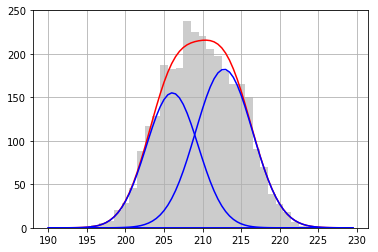

In [8]:
draw(params) ###variationalinference2draw

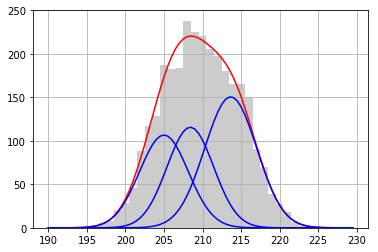

In [9]:
draw(params_history[100])

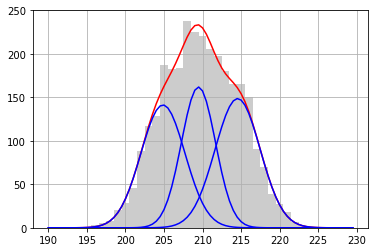

In [10]:
draw(params_history[10])

In [11]:
params_history

{10:            tau         zeta      mu_avg       alpha         beta     z_std
 0  1017.351576  1017.351576  204.863798  509.175788  4167.085746  2.860766
 1   891.652255   891.652255  209.474450  446.326127  2182.511912  2.211323
 2  1093.996170  1093.996170  214.555711  547.498085  4695.431563  2.928508,
 20:            tau         zeta      mu_avg       alpha         beta     z_std
 0   992.149113   992.149113  204.956920  496.574556  4421.021450  2.983796
 1   878.326094   878.326094  209.305862  439.663047  2717.587509  2.486176
 2  1132.524793  1132.524793  214.329412  566.762396  5359.382106  3.075083,
 30:            tau         zeta      mu_avg       alpha         beta     z_std
 0   967.792943   967.792943  204.991492  484.396472  4482.183072  3.041896
 1   872.143327   872.143327  209.164867  436.571663  3043.002179  2.640118
 2  1163.063730  1163.063730  214.183395  582.031865  5794.791932  3.155335,
 40:            tau         zeta      mu_avg       alpha         beta    